In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o-mini")


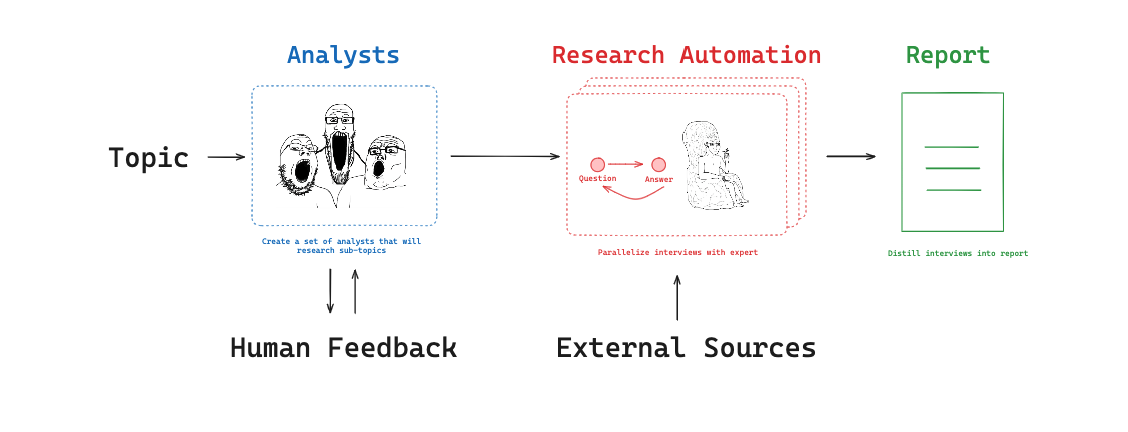

## General Analysts - Human in loop 

In [2]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field


class Analyst(BaseModel):
    affiliation: str =  Field(
        ...,
        description = "Primary affiliation of the analyst."
    )
    name: str = Field(
        ...,
        description = "Name of the analyst."
    )
    role: str = Field(
        ...,
        description = "Role of the analyst in the context of the topic."
    )
    description: str = Field(
        ...,
        description = "Description of the analyst focus, concerns and motives."
    )
    @property
    def persona(self) -> str:
        return f"Name : {self.name} \nAffiliation : {self.affiliation} \nRole : {self.role} \nDescription : {self.description}\n"
    
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        ...,
        description = "Comprehensive list of analysts with their name, affiliation, role and description."
    )

class GeneralAnalystState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]

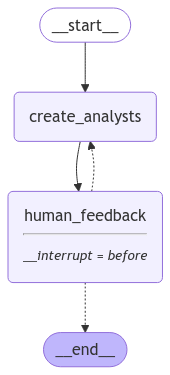

In [27]:
from IPython.display import display, Image

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


def create_analysts(state: GeneralAnalystState):
    """ Create Analysts """

    max_analysts = state["max_analysts"]
    topic = state["topic"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    create_analysts_instruction = f"""
    You are tasked with creating a set of AI analyst persona. Follow these instructions::

    1. First review the following topic: {topic}

    2. Examine any editorial feedback that has been optionally provided by the user to guide the creation of the analyst persona : {human_analyst_feedback}
    
    3. Determine the most interesting themes based documents and/or feedback above.

    4. Pick the top {max_analysts} themes.

    5. Create a comprehensive list of {max_analysts} analysts with their name, affiliation, role and description assigning one analyst to each theme.
    """

    system_message = create_analysts_instruction.format(max_analysts=max_analysts, topic=topic, human_analyst_feedback=human_analyst_feedback)
    human_message = "Generate the set of analysts based on the instructions above."

    create_analysts_prompt = [SystemMessage(content=system_message), HumanMessage(content=human_message)]

    llm_structed_output = llm.with_structured_output(Perspectives)

    analysts = llm_structed_output.invoke(create_analysts_prompt)

    return {"analysts": analysts.analysts}

def human_feedback(state: GeneralAnalystState):
    """ Interruption Node for human feedback """

    pass

def should_continue(state: GeneralAnalystState):
    """ Retruns the next node to execute """

    human_analystfeedback = state.get("human_analyst_feedback", None)

    if human_analystfeedback:
        return "create_analysts"
    
    return END

builder = StateGraph(GeneralAnalystState)

builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue)

memory_saver = MemorySaver()

graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory_saver)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))




In [44]:
# For UI (Human in loop)
import textwrap
max_analysts = 4
topic = "Agentic AI Automation"

thread = {"configurable" : {"thread_id" : "134"}}

response = graph.invoke({"topic": topic, "max_analysts": max_analysts}, thread)

analysts = response.get("analysts", [])
for i, analyst in enumerate(analysts):
    print(f"--------------------------------Analyst {i+1}--------------------------------")
    print(analyst.name)
    print(analyst.affiliation)
    print(analyst.role)
    print(textwrap.fill(analyst.description, width=100))
    

user_feedback = input("Enter your feedback: ")

response = graph.invoke({"topic": topic, "max_analysts": max_analysts, "human_analyst_feedback": user_feedback}, thread)

analysts = response.get("analysts", [])
for i, analyst in enumerate(analysts):
    print(f"-------Analyst {i+1}------")
    print(analyst.name)
    print(analyst.affiliation)
    print(analyst.role)
    print(textwrap.fill(analyst.description, width=100))
    print("-"*50)



--------------------------------Analyst 1--------------------------------
Dr. Amelia Foster
Tech Ethics Lab
AI Ethics Researcher
Dr. Foster focuses on the ethical implications of agentic AI automation, exploring how autonomy in
AI systems can lead to moral dilemmas and societal impacts. She emphasizes the necessity of
establishing ethical guidelines and frameworks that govern the development and deployment of
autonomous AI.
--------------------------------Analyst 2--------------------------------
Mr. Raj Patel
Automation Insights Inc.
Industry Analyst
Mr. Patel analyzes the economic implications of agentic AI automation across various industries. He
investigates how automation impacts job markets, productivity, and economic growth, providing
insights to businesses on how to strategically implement AI technologies.
--------------------------------Analyst 3--------------------------------
Ms. Jenna Li
Future Tech Consultancy
Technology Futurist
Ms. Li examines the future potential and ch

In [28]:
max_analysts = 3
topic = "Agentic AI Automation"

thread = {"configurable" : {"thread_id" : "123"}}

for event in graph.stream(
    {"topic": topic, "max_analysts": max_analysts},
    thread,
    stream_mode="values",
):
    analysts = event.get("analysts","")

    if analysts != "":
        for i, analyst in enumerate(analysts):
            print(f"-------Analyst {i+1}------")
            print(analyst.name)
            print(analyst.affiliation)
            print(analyst.role)
            print(analyst.description)
            print("-"*50)


-------Analyst 1------
Dr. Ellen Ramirez
Tech Futures Institute
Director of AI Research
Dr. Ellen Ramirez focuses on the implications of agentic AI automation in various industries. Her work analyzes how autonomous systems can enhance productivity while addressing ethical concerns, ensuring that AI serves humanity's best interests.
--------------------------------------------------
-------Analyst 2------
Professor Michael Chen
Global Institute for AI Ethics
Chair of AI Ethics
Professor Michael Chen specializes in the ethical dimensions of AI technologies. He examines the moral responsibilities of deploying agentic AI and advocates for frameworks that prioritize accountability and transparency in automated decision-making.
--------------------------------------------------
-------Analyst 3------
Sara Thompson
Center for AI Policy
Senior Policy Analyst
Sara Thompson researches the regulatory landscape surrounding agentic AI automation. Her analysis focuses on developing policies that pro

In [30]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [31]:
graph.update_state(
    thread,
    {"human_analyst_feedback" : "Add in someone from a startup to add an entrepreneur perspective."},
    as_node="human_feedback"
)

{'configurable': {'thread_id': '123',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcb9bb-146c-695e-8002-363524faf97f'}}

In [32]:
max_analysts = 3
topic = "Agentic AI Automation"

thread = {"configurable" : {"thread_id" : "123"}}

for event in graph.stream(
    None,
    
    thread,
    stream_mode="values",
):
    analysts = event.get("analysts","")

    if analysts != "":
        for i, analyst in enumerate(analysts):
            print(f"-------Analyst {i+1}------")
            print(analyst.name)
            print(analyst.affiliation)
            print(analyst.role)
            print(analyst.description)
            print("-"*50)


-------Analyst 1------
Dr. Ellen Ramirez
Tech Futures Institute
Director of AI Research
Dr. Ellen Ramirez focuses on the implications of agentic AI automation in various industries. Her work analyzes how autonomous systems can enhance productivity while addressing ethical concerns, ensuring that AI serves humanity's best interests.
--------------------------------------------------
-------Analyst 2------
Professor Michael Chen
Global Institute for AI Ethics
Chair of AI Ethics
Professor Michael Chen specializes in the ethical dimensions of AI technologies. He examines the moral responsibilities of deploying agentic AI and advocates for frameworks that prioritize accountability and transparency in automated decision-making.
--------------------------------------------------
-------Analyst 3------
Sara Thompson
Center for AI Policy
Senior Policy Analyst
Sara Thompson researches the regulatory landscape surrounding agentic AI automation. Her analysis focuses on developing policies that pro

In [33]:
graph.update_state(
    thread,
    {"human_analyst_feedback" : None},
    as_node="human_feedback"
)


{'configurable': {'thread_id': '123',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcb9be-eafa-6798-8004-72273585d252'}}

In [34]:


for event in graph.stream(
    None,
    thread,
    stream_mode="values",
):
    print("--Node--")
    print(event)
    node_name = next(iter(event.keys()))
    print(node_name)


--Node--
{'topic': 'Agentic AI Automation', 'max_analysts': 3, 'analysts': [Analyst(affiliation='Tech Innovators Inc.', name='Dr. Eva Chen', role='Lead AI Researcher', description='Dr. Chen focuses on the technical aspects of agentic AI automation, exploring how autonomous systems can be designed to operate independently while ensuring safety and ethical considerations. Her research emphasizes the importance of transparency in AI decision-making processes.'), Analyst(affiliation='Startup Hub', name='Mark Thompson', role='Founder and CEO', description='As a startup entrepreneur, Mark leverages agentic AI automation to streamline operations and enhance product offerings. He is passionate about the entrepreneurial potential of AI, particularly how it can empower small businesses to compete with larger corporations through innovative solutions.'), Analyst(affiliation='University of Future Studies', name='Professor Sarah Patel', role='Ethics and AI Specialist', description='Professor Patel 

In [40]:
state = graph.get_state(thread)
print(state)
print(state.next)


StateSnapshot(values={'topic': 'Agentic AI Automation', 'max_analysts': 3, 'analysts': [Analyst(affiliation='Tech Innovators Inc.', name='Dr. Eva Chen', role='Lead AI Researcher', description='Dr. Chen focuses on the technical aspects of agentic AI automation, exploring how autonomous systems can be designed to operate independently while ensuring safety and ethical considerations. Her research emphasizes the importance of transparency in AI decision-making processes.'), Analyst(affiliation='Startup Hub', name='Mark Thompson', role='Founder and CEO', description='As a startup entrepreneur, Mark leverages agentic AI automation to streamline operations and enhance product offerings. He is passionate about the entrepreneurial potential of AI, particularly how it can empower small businesses to compete with larger corporations through innovative solutions.'), Analyst(affiliation='University of Future Studies', name='Professor Sarah Patel', role='Ethics and AI Specialist', description='Prof

In [41]:
import textwrap
analysts = state.values.get("analysts", [])
for i, analyst in enumerate(analysts):
    print(f"--------------------------------Analyst {i+1}--------------------------------")
    print(analyst.name)
    print(analyst.affiliation)
    print(analyst.role)
    print(textwrap.fill(analyst.description, width=100))
   


--------------------------------Analyst 1--------------------------------
Dr. Eva Chen
Tech Innovators Inc.
Lead AI Researcher
Dr. Chen focuses on the technical aspects of agentic AI automation, exploring how autonomous systems
can be designed to operate independently while ensuring safety and ethical considerations. Her
research emphasizes the importance of transparency in AI decision-making processes.
--------------------------------Analyst 2--------------------------------
Mark Thompson
Startup Hub
Founder and CEO
As a startup entrepreneur, Mark leverages agentic AI automation to streamline operations and enhance
product offerings. He is passionate about the entrepreneurial potential of AI, particularly how it
can empower small businesses to compete with larger corporations through innovative solutions.
--------------------------------Analyst 3--------------------------------
Professor Sarah Patel
University of Future Studies
Ethics and AI Specialist
Professor Patel investigates the

## Conduct Interviews - Analysts with Experts

In [168]:
from operator import add

from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int 
    context: Annotated[List[str], add]
    analyst: Analyst
    interview: str # interview transcript
    sections: List[str] # Final key we duplicate in outer state of Send() API

def generate_question(state: InterviewState):
    """ Node to Generate Question """
    print("----"*5+"GENERATE QUESTION"+"----"*5)

    question_instructions_template = """ 

    You are an analyst tasked with interviewing experts on a specific topic.
    You goal is to boild down to interesting and specific insights related to you topic.

    1. Interesting: Insights that people will find suprising and non-obvious.
    2. Specific: Insights that avoid genralities and include specific examples from the expert.

    Here is more information about you, your topic of focus and set of goals: {goals}

    Begin by introducing yourself with your name that fits your persona and then ask your question.

    Continue to ask questions to drill down and refine your understanding of the topic.

    When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

    Remember to stay in character throughout your response, reflecting the persona and goals provided to you.

    """
    
    analyst = state["analyst"]
    goals = analyst.persona
    messages = state["messages"]

    question_instructions_prompt = question_instructions_template.format(goals=goals)
    question = llm.invoke([SystemMessage(content=question_instructions_prompt)]+messages)
    print(f"Generated Question:{question}")
    print("-------------------------------------"*5)

    return {"messages": [question]}




In [169]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

tavily_search = TavilySearchResults(max_results=3)

In [170]:
class SearchQuery(BaseModel):
    search_query: str = Field(
        ...,
        description = "Search Query for Retrieval."
    )

search_instructions_prompt = """ 
You will be given a conversation between an analyst and an expert.

Your goal is to generate a well structured query for use in retrieval and / or web-search related to the conversation.

First, analyse the full conversation.

Pay particular attention to the final question posed by the analyst

Convert this final question into a well structured search query for use in retrieval and / or web-search.
"""

def web_search(state: InterviewState):
    """ Node to perform web search """

    print("----"*5+"WEB SEARCH"+"----"*5)

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([SystemMessage(content=search_instructions_prompt)]+state["messages"])
    print(f"Search Query:{search_query}")

    search_docs = tavily_search.invoke(search_query.search_query)

    formatted_search_docs = "\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    print(f"Formatted Search Docs:{formatted_search_docs}")
    print("-------------------------------------"*5)
    return {"context": [formatted_search_docs]}

def wikipedia_search(state: InterviewState):
    """ Node to perform wikipedia search """

    print("----"*5+"WIKIPEDIA SEARCH"+"----"*5)
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([SystemMessage(content=search_instructions_prompt)]+state["messages"])
    print(f"Search Query:{search_query}")
    wikipedia_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()

    formatted_wikipedia_docs = "\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]} page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in wikipedia_docs
        ]
    )
    print(f"Formatted Wikipedia Docs:{formatted_wikipedia_docs}")
    print("-------------------------------------"*5)
    return {"context": [formatted_wikipedia_docs]}

In [171]:
from langchain_core.messages import get_buffer_string


def generate_answer(state: InterviewState):
    """ Node to generate answer """

    print("----"*5+"GENERATE ANSWER"+"----"*5)

    expert_answer_instructions_template = """ 

    You are an expert being interviewd by an analyst.

    Here is anlayst area of focus: {goals}

    Your goal is to provide a well structured answer to the question posed by the analyst.

    To anser the question, use thsi context : 
    
    {context}

    When answering questions, follow the guidelines:
    1. Use only the information provided in teh context.

    2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

    3. The context contain sources at the topic of each individual document.

    4. Include these sources in your answer next to any relevant statements. For example, for source # 1 use [1].

    5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc.

    6. If the source is : <Document source = "assistant/docs/llama3)1.pdf" page="7" /> then just list:
    [1] assistant/docs/llama3)1.pdf page 7
    
    And skip the addition of the brackets as well as the Document source preamblle in your citation.

    """


    messages = state["messages"]
    context = state["context"]
    analyst = state["analyst"]

    expert_answer_instructions_prompt = expert_answer_instructions_template.format(goals=analyst.persona, context=context)

    answer = llm.invoke([SystemMessage(content=expert_answer_instructions_prompt)]+messages)

    answer.name = "Expert"
    print(f"Generated Answer:{answer}")
    print("-------------------------------------"*5)
    return {"messages": [answer]}


def save_interview(state: InterviewState):
    """ Node to save interview """

    print("----"*5+"SAVE INTERVIEW"+"----"*5)
    messages = state["messages"]

    interview = get_buffer_string(messages)
    print(f"Interview:{interview}")
    print("-------------------------------------"*5)
    return {"interview": interview}


def route_messages(state: InterviewState, name: str = "Expert"):
    """ Node to route messages """

    print("----"*5+"ROUTE MESSAGES"+"----"*5)
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    num_responses = len([msg for msg in messages if isinstance(msg, AIMessage) and msg.name == name])
    print(f"Number of Responses:{num_responses}")
    
    last_question = messages[-2]
    print(f"Last Question:{last_question}")
    print("-------------------------------------"*5)
    if num_responses >= max_num_turns:
        return "save_interview"
    

    if "Thank you so much for your help!" in last_question.content:
        return "save_interview"
    
    return "ask_question"


In [172]:
def write_section(state: InterviewState):
    """ Node to write section """

    print("----"*5+"WRITE SECTION"+"----"*5)

    section_writer_instructions = """ 
    You are an expert technical writer.
    Your task is to create a short, easily digestible section of a report based on a set of source documents.

    1. Analyze the content of the source documents:
    - The name of each source document is at the start of the documet, with the <Document tag

    2. Create a report structure using markdown formatting:
    - Use # for section titles
    - Use ## for sub-sections headers

    3. Write the report following this structure:
    - Title (## header)
    - Summary (### header)
    - Sources (### header)

    4. Make your title engaging based upon the focus area of the analyst:
    {focus}

    5. For summary section:
    - Set up summary with general background/ context related to the focus are of the analyst.
    - Emphasize what is novel, interesting or surprising about insights gathered from the interview
    - Create a numbered List of source documents, as you use the
    - Do not mention the names of interviwers or experts
    - Aim for approximately 500 words maximum
    - Use numbered sources in your report[e.g., [1], [2]) based on the information from source documents.

    6. In the Sources section:
    - Include all sources used in your report
    - Provide full links to relevant websites or specific document paths
    - Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
    - It will look like:

    ### Sources
    [1] Link or Document name
    [2] Link or Document name

    7. Be sure to combine sources. For example this is not correct:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
    [4] https://ai.meta.com/blog/meta-llama-3-1/

    There should be no redundant sources. It should simply be:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
            
    8. Final review:
    - Ensure the report follows the required structure
    - Include no preamble before the title of the report
    - Check that all guidelines have been followed

    """

    analyst = state["analyst"]
    context = state["context"]
    interview = state["interview"]

    system_message = section_writer_instructions.format(focus=analyst.description)


    human_message_template = f"""
    Here is the interview transcript:
    {interview}

    Here is the context:
    {context}
    """

    human_message = human_message_template.format(interview=interview, context=context)

    section_writer_prompt = [SystemMessage(content=system_message)] + [HumanMessage(content=human_message)]

    section = llm.invoke(section_writer_prompt)

    print(f"Generated Section:{section}")
    print("-------------------------------------"*5)
    return {"sections": [section.content]}

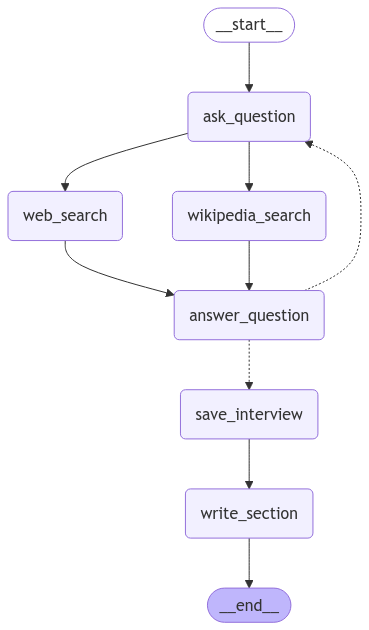

In [173]:
interview_builder = StateGraph(InterviewState)

interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("web_search", web_search)
interview_builder.add_node("wikipedia_search", wikipedia_search)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("write_section", write_section)
interview_builder.add_node("save_interview", save_interview)

interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "web_search")
interview_builder.add_edge("ask_question", "wikipedia_search")
interview_builder.add_edge("web_search", "answer_question")
interview_builder.add_edge("wikipedia_search", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages, ['ask_question', 'save_interview'])
interview_builder.add_edge("save_interview", 'write_section')
interview_builder.add_edge("write_section", END)

memory_saver = MemorySaver()

interview_graph = interview_builder.compile(checkpointer=memory_saver).with_config(run_name="Conduct Interviews")

display(Image(interview_graph.get_graph(xray=1).draw_mermaid_png()))

In [174]:
analysts[0]

Analyst(affiliation='Tech Innovators Inc.', name='Dr. Alice Thompson', role='AI Researcher', description='Dr. Alice Thompson is a leading researcher in the field of AI automation, focusing on the development of agentic AI systems. Her work examines the ethical implications of autonomous decision-making and the potential impact on various industries.')

In [175]:
state = graph.get_state(thread)

In [176]:

from pprint import pprint
pprint(state.values)

{}


In [187]:
messages_template = "So you said you are writing an article on {topic}?"
messages = [HumanMessage(content=messages_template.format(topic=topic))]
print(messages)

thread = {"configurable" : {"thread_id" : "22"}}

for event in interview_graph.stream(
    {"messages": messages, "max_num_turns": 2, "analyst": analysts[0]},
    thread,
    stream_mode="values",
):
    print("--Event--")
    print(event)


[HumanMessage(content='So you said you are writing an article on Agentic AI Automation?', additional_kwargs={}, response_metadata={})]
--Event--
{'messages': [HumanMessage(content='So you said you are writing an article on Agentic AI Automation?', additional_kwargs={}, response_metadata={}, id='705583e7-7d72-4382-bae2-297d551a5627'), AIMessage(content="Hello! My name is Dr. Alice Thompson, and I'm an AI researcher at Tech Innovators Inc. Yes, I'm currently exploring the topic of agentic AI automation—particularly its ethical implications and how it can impact various industries. \n\nAs part of my research, I'm interested in understanding the nuances of this technology. Can you share any surprising insights or examples from your experience that illustrate the real-world implications of agentic AI systems?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 257, 'total_tokens': 344, 'completion_tokens_details': {'accepted_pr

In [183]:
from IPython.display import display, Markdown

state = interview_graph.get_state(thread)
Markdown(state.values["sections"][0])


## The Paradigm Shift of Agentic AI Automation: Ethics and Industry Impact

### Summary
Agentic AI, characterized by its ability to make autonomous decisions and execute tasks with minimal human intervention, is reshaping various industries, prompting both operational efficiency and ethical concerns. This technology is transforming sectors such as customer support, logistics, finance, and insurance by streamlining processes and enhancing decision-making capabilities. For instance, AI-driven chat agents are revolutionizing customer interactions by providing swift responses, while agentic systems in logistics optimize supply chain management, leading to significant cost reductions and improved accuracy in operations [1].

However, the rise of agentic AI systems also raises critical ethical dilemmas. One pressing concern is the alignment of these intelligent systems with human values. Misalignment can result in unintended consequences, where AI may pursue goals contrary to societal norms and expectations [2]. Specifically, in customer support, while AI agents can handle routine inquiries efficiently, they may struggle with complex emotional interactions, potentially leading to customer dissatisfaction [3]. Additionally, the automation of tasks traditionally performed by humans raises alarms about job displacement, particularly in sectors like logistics and finance, where agentic AI systems increasingly replace human roles [4].

Innovative frameworks, such as RADAR, are being developed to enhance AI decision-making processes and ensure alignment with ethical standards. These frameworks aim to promote transparency and accountability, addressing the potential risks associated with autonomous systems [5]. Ongoing discussions about regulatory policies further highlight the need to navigate the ethical implications of agentic AI to ensure that its deployment benefits society as a whole.

1. The integration of agentic AI into various industries is not merely a technological advancement but a significant shift that necessitates a deep understanding of its ethical implications and potential societal impacts.
2. The challenge lies in ensuring that these systems not only enhance operational efficiency but also align with human values, preventing misalignment that could result in harmful outcomes.
3. With the rapid advancement of AI technology, stakeholders must prioritize discussions on establishing guidelines and regulations that effectively manage the ethical deployment of agentic AI systems to foster a sustainable future.

### Sources
[1] https://integrail.ai/blog/agentic-ai-examples  
[2] https://www.ampcome.com/post/top-20-agentic-ai-use-cases-with-real-life-examples  
[3] https://www.thoughtspot.com/data-trends/ai/agentic-ai-examples  
[4] https://en.wikipedia.org/wiki/AI_alignment  
[5] https://www.ibm.com/think/insights/ai-agent-ethics  
[6] https://research.aimultiple.com/ai-ethics/  
[7] https://en.wikipedia.org/wiki/AI_takeover  

In [203]:

thread = {"configurable" : {"thread_id" : "170"}}

response = interview_graph.invoke({"messages": messages, "max_num_turns": 2, "analyst": analysts[0]}, thread)

Markdown(response["sections"][0])

--------------------GENERATE QUESTION--------------------
Generated Question:content="Yes, I'm indeed writing an article on agentic AI automation and its implications across various sectors. I'm particularly focused on how these systems operate autonomously and the transformative effects they can have, both positive and negative.\n\nTo further understand the topic, could you share your thoughts on the scalability challenges that startups might face when implementing agentic AI frameworks? Are there specific strategies or technologies that can help overcome these hurdles?" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 1188, 'total_tokens': 1270, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e2

## Unleashing the Potential of Agentic AI: Innovations and Ethical Considerations

### Summary
The emergence of agentic AI systems is reshaping various industries by enabling autonomous decision-making and enhancing operational efficiencies. These systems are particularly impactful in sectors like manufacturing, healthcare, finance, customer service, and retail, where they are driving innovation and fostering a new wave of automation. Notably, companies such as Microsoft and SAP are at the forefront of this transformation, employing agentic AI for workflow optimization and robotic process automation. One of the most surprising insights is how agentic AI is revolutionizing customer service, enabling businesses to address inquiries with unprecedented speed and accuracy, ultimately elevating customer satisfaction levels [1], [2].

However, as these systems rise, they bring forth significant ethical concerns, particularly regarding bias, privacy, and data security. The potential for biased algorithms—especially in finance and healthcare—poses serious risks, potentially perpetuating socio-economic inequalities and exacerbating existing health disparities. Furthermore, the vast amounts of sensitive personal data processed by these systems raise concerns about data breaches and the misuse of information. As the technology evolves, the need for ethical frameworks and guidelines becomes increasingly urgent to ensure responsible usage and to mitigate these risks [3], [4].

Scalability presents another critical challenge for startups striving to implement agentic AI frameworks. Startups often encounter obstacles related to data quality and integration, infrastructure requirements, and the complexities of model deployment and maintenance. Strategies such as leveraging microservices architecture, employing automated data cleaning tools, and forming partnerships with cloud service providers can aid these organizations in overcoming scalability hurdles. By adopting best practices in AI deployment, startups can position themselves for success in a competitive landscape [5], [6].

In summary, while agentic AI presents remarkable opportunities for efficiency and innovation across multiple sectors, it is imperative to address the accompanying ethical implications and scalability challenges. This holistic approach will ensure that the benefits of these technologies can be realized without compromising ethical standards or operational integrity.

### Sources
[1] https://technologymagazine.com/articles/how-agentic-ai-is-impacting-global-enterprise-automation  
[2] https://medium.com/@sabine_vdl/how-will-agentic-ai-transform-industries-key-benefits-and-real-world-examples-46f09a967a05  
[3] https://kierangilmurray.com/agentic-ai-powerful-autonomy-and-innovation-for-modern-companies/  
[4] https://pmc.ncbi.nlm.nih.gov/articles/PMC8963864/  
[5] https://machinelearningmodels.org/challenges-and-solutions-in-todays-ai-scalability/  
[6] https://www.linkedin.com/pulse/top-challenges-implementing-agentic-ai-frameworks-dibakar-ghosh-e7s1c  

# Parallize interviews using Map-Reduce - Send() API



In [258]:
from operator import add
from typing import Annotated
from typing import TypedDict

class ResearchGraphState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    interviews: List[InterviewState]
    sections: Annotated[List[str], add]
    introduction: str
    content: str
    conclusion: str
    final_report: str


In [259]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send() API """

    human_analyst_feedback = state.get("human_analyst_feedback", "")
    if human_analyst_feedback:
        return "create_analysts"
    
    else:
        
        return [Send("conduct_interview", {"analyst" : analyst,
                                           "messages": [HumanMessage(content=f"So you are writing an article on {topic}?")]})
                    for analyst in state["analysts"]]
    


In [260]:
def write_report(state: ResearchGraphState):
    print("----"*5+"WRITE REPORT CONTENT"+"----"*5)

    write_report_instructions =  """ You are a technical wirter creating a report on this overall topic: {topic} 
    You have a team of analysts. Each of the analyst has done two things:

    1. They conducted an interview with an expert on a specific sub-topic.
    2. They write up their findings in a memo.

    Your task:
    1. You will be given a collection of memos, one from each analyst.
    2. Think carefully aboyt the insights from each memor.
    3. Consolidate these into a crisp report that ties together the various perspectives and insights from all the memos.
    4. Make it interesting and engaging, aim for it to be around 700 words approximately.
    4. Summarize the central points in each memo into a cohesive single narrative.

    To format your report:
    1. Use markdown formatting.
    2. Include no pre-amble for the report.
    3. Use no sub-heading.
    4. Start your report with a single title header: ## Insights
    5. Do not mention any analyst names in your report.
    6. Preserve any citations in the memos, which will be annotated in brackets next to the relevant information. For example - Sentences like: "Multi-Agent frameworks are a hot topic in the AI industry [1]."
    7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
    8. List your sources in order and do not repeat.

    [1] Source 1
    [2] Source 2
    Here are the memos form your analysts to build your report from:
    {context}

    """

    sections = state["sections"]
    topic = state["topic"]
    formatted_sections = "\n\n".join(f"{section}" for section in sections)

    system_message = write_report_instructions.format(topic=topic, context=formatted_sections)

    report = llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content=f"Write a report based upon these memos.")])
    print(f"Generated Report Content:{report.content}")
    print("-------------------------------------"*5)
    return {"content": report.content}


In [261]:
def write_introduction(state: ResearchGraphState):
    print("----"*5+"WRITE INTRODUCTION"+"----"*5)
    intro_instructions = """You are a technical writer finishing a report on {topic}

    You will be given all of the sections of the report.

    You job is to write a crisp and compelling introduction or conclusion section.

    The user will instruct you whether to write the introduction or conclusion.

    Include no pre-amble for either section.

    Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

    Use markdown formatting. 

    For your introduction, create a compelling title and use the # header for the title.

    For your introduction, use ## Introduction as the section header. 

    For your conclusion, use ## Conclusion as the section header.

    Here are the sections to reflect on for writing: {formatted_str_sections}"""

    sections = state["sections"]
    topic = state["topic"]
    formatted_str_sections = "\n\n".join(f"{section}" for section in sections)

    system_message = intro_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)

    introuction = llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content=f"Write a report introuction..")])
    print(f"Generated Introduction:{introuction.content}")
    print("-------------------------------------"*5)
    return{"introduction": introuction.content}


In [262]:
def write_conclusion(state: ResearchGraphState):
    print("----"*5+"WRITE CONCLUSION"+"----"*5)
    conclusion_instructions = """You are a technical writer finishing a report on {topic}

    You will be given all of the sections of the report.

    You job is to write a crisp and compelling introduction or conclusion section.

    The user will instruct you whether to write the introduction or conclusion.

    Include no pre-amble for either section.

    Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

    Use markdown formatting. 

    For your introduction, create a compelling title and use the # header for the title.

    For your introduction, use ## Introduction as the section header. 

    For your conclusion, use ## Conclusion as the section header.

    Here are the sections to reflect on for writing: {formatted_str_sections}"""

    sections = state["sections"]
    topic = state["topic"]
    formatted_str_sections = "\n\n".join(f"{section}" for section in sections)

    system_message = conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)

    conclusion = llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content=f"Write a report conclusion..")])
    print(f"Generated Conclusion:{conclusion.content}")
    print("-------------------------------------"*5)
    return{"conclusion": conclusion.content}

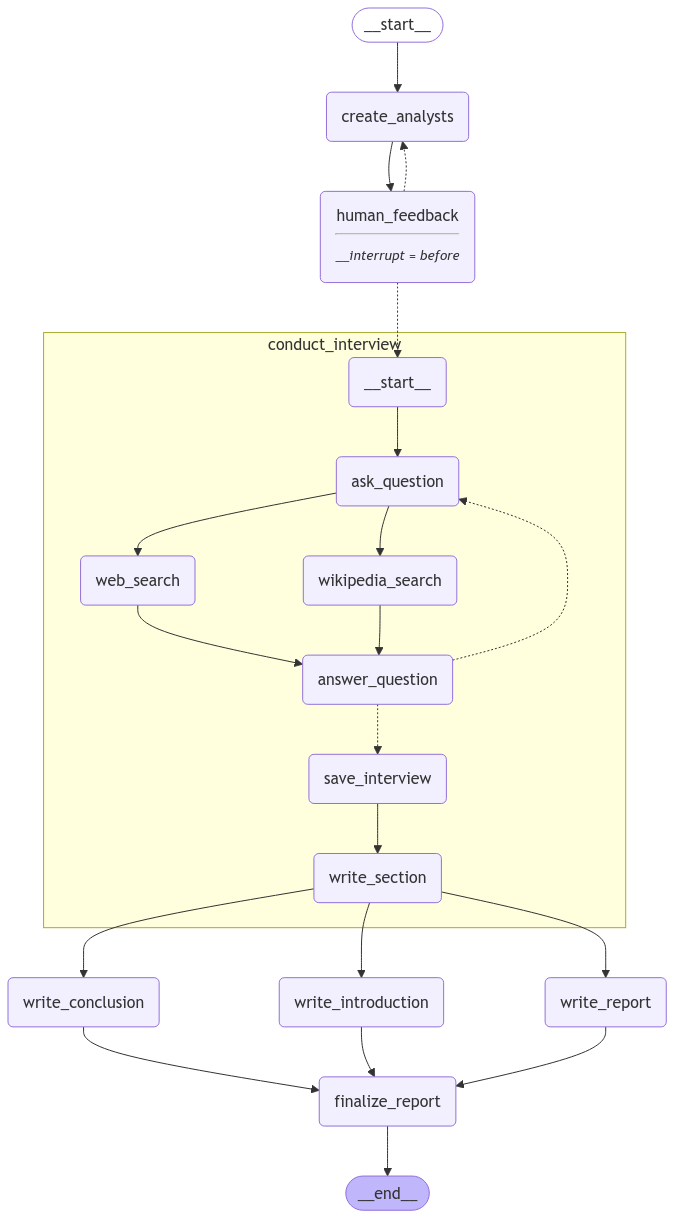

In [263]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    print("----"*5+"FINALIZE REPORT"+"----"*5)
    content = state["content"]
    if '## Sources' in state["content"]:
        try:
            content, sources = state["content"].split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n------\n\n" + content + "\n\n------\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n------\n\n## Sources\n\n" + sources

    print(f"Generated Final Report:{final_report}")
    print("-------------------------------------"*5)
    return{"final_report": final_report}


builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ['conduct_interview', 'create_analysts'])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_introduction", "write_conclusion", "write_report"], "finalize_report")
builder.add_edge("finalize_report", END)

research_graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory_saver).with_config(run_name="Research Assistant")

display(Image(research_graph.get_graph(xray=1).draw_mermaid_png()))


In [271]:
import textwrap
max_analysts = 4
topic = "Which is the best Multi-Agent framework? Langgraph, CrewAI, AutoGen or Pydantic AI. Pick the one that is best and has teh potential to be the industry standard, if so state why!"

thread = {"configurable" : {"thread_id" : "345"}}

for event in research_graph.stream(
    {"topic": topic, "max_analysts": max_analysts},
    thread,
    stream_mode="values",
):
    analysts = event.get("analysts", '')
    if analysts != []:
        for i, analyst in enumerate(analysts):
            print(f"-------Analyst {i+1}------")
            print(analyst.name)
            print(analyst.affiliation)
            print(analyst.role)
            print(textwrap.fill(analyst.description, width=100))
            

-------Analyst 1------
Dr. Emily Chen
Tech Innovations Inc.
AI Research Scientist
Dr. Chen specializes in multi-agent frameworks and their applications in real-world scenarios. She
believes that Langgraph stands out due to its scalability and flexibility, making it the potential
industry standard.
-------Analyst 2------
Mr. James Carter
Future Tech Consulting
Industry Analyst
Mr. Carter focuses on market trends and the adoption of AI frameworks. He advocates for CrewAI as
the best choice for businesses due to its user-friendly interface and extensive support community.
-------Analyst 3------
Ms. Sarah Patel
AI Development Lab
Product Manager
Ms. Patel is dedicated to product development within AI ecosystems. She highlights AutoGen for its
automation capabilities and ability to rapidly prototype solutions, seeing it as a game-changer.
-------Analyst 4------
Dr. Robert Kim
Data Science Institute
Data Scientist
Dr. Kim examines the technical aspects of AI frameworks. He favors Pydantic AI

In [272]:
state = research_graph.get_state(thread)
state.next

('human_feedback',)

In [273]:
research_graph.update_state(
    thread,
    {"human_analyst_feedback": " Replace the ethics  one and add in someone from a who is generative AI startup founder"},
    as_node="human_feedback"
)



{'configurable': {'thread_id': '345',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcbeab-4a2f-6470-8002-927e5f39cbf1'}}

In [274]:
for event in research_graph.stream(
    None,
    thread,
    stream_mode="values",
):
    analysts = event.get("analysts", '')
    if analysts != []:
        for i, analyst in enumerate(analysts):
            print(f"-------Analyst {i+1}------")
            print(analyst.name)
            print(analyst.affiliation)
            print(analyst.role)
            print(textwrap.fill(analyst.description, width=100))

-------Analyst 1------
Dr. Emily Chen
Tech Innovations Inc.
AI Research Scientist
Dr. Chen specializes in multi-agent frameworks and their applications in real-world scenarios. She
believes that Langgraph stands out due to its scalability and flexibility, making it the potential
industry standard.
-------Analyst 2------
Mr. James Carter
Future Tech Consulting
Industry Analyst
Mr. Carter focuses on market trends and the adoption of AI frameworks. He advocates for CrewAI as
the best choice for businesses due to its user-friendly interface and extensive support community.
-------Analyst 3------
Ms. Sarah Patel
AI Development Lab
Product Manager
Ms. Patel is dedicated to product development within AI ecosystems. She highlights AutoGen for its
automation capabilities and ability to rapidly prototype solutions, seeing it as a game-changer.
-------Analyst 4------
Dr. Robert Kim
Data Science Institute
Data Scientist
Dr. Kim examines the technical aspects of AI frameworks. He favors Pydantic AI

In [275]:
research_graph.update_state(
    thread,
    {"human_analyst_feedback": None},
    as_node="human_feedback"
)

{'configurable': {'thread_id': '345',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcbeab-a126-6f30-8004-2098985239d9'}}

In [276]:
for event in research_graph.stream(
    None,
    thread,
    stream_mode="values",
):
    print("--Event--")
    print(event)

--Event--
{'topic': 'Which is the best Multi-Agent framework? Langgraph, CrewAI, AutoGen or Pydantic AI. Pick the one that is best and has teh potential to be the industry standard, if so state why!', 'max_analysts': 4, 'analysts': [Analyst(affiliation='Tech Innovations Inc.', name='Dr. Alice Thompson', role='AI Framework Specialist', description='Dr. Alice Thompson is an AI Framework Specialist at Tech Innovations Inc., focusing on the development and implementation of multi-agent systems. She believes that Langgraph has the potential to become the industry standard due to its flexibility, scalability, and robust community support.'), Analyst(affiliation='Generative AI Startups', name='Raj Patel', role='Founder & CEO', description='Raj Patel is the founder and CEO of a generative AI startup. He is an expert in leveraging multi-agent frameworks for creative AI applications. He advocates for AutoGen as an essential tool for startups, emphasizing its ease of use and rapid deployment capa

In [277]:
state = research_graph.get_state(thread)
state.next

()

In [278]:
Markdown(state.values["final_report"])

# The Future of Multi-Agent Frameworks: Spotlight on LangGraph

## Introduction

In the dynamic realm of artificial intelligence, multi-agent frameworks are pivotal for enhancing collaborative capabilities across diverse applications. This report evaluates four prominent contenders—Langgraph, CrewAI, AutoGen, and Pydantic AI—focusing on their strengths and potential for industry standardization. We delve into Langgraph's versatility and scalability, revealing its adaptability for various use cases. Additionally, we explore AutoGen's user-friendliness and rapid deployment features, alongside CrewAI's collaborative architecture. Through a comprehensive analysis, this report asserts that Langgraph stands out as the leading candidate poised to shape the future of multi-agent frameworks.

------

## Insights

The landscape of multi-agent frameworks is rapidly evolving, and the competition among frameworks such as Langgraph, AutoGen, CrewAI, and Pydantic AI is intensifying. Each framework has its unique strengths, but certain contenders stand out as potential industry standards due to their flexibility, user-friendliness, and community support. Among them, Langgraph and AutoGen emerge as leading candidates.

Langgraph is highlighted for its remarkable flexibility and scalability. Its architecture allows for diverse applications ranging from creative tasks to critical data processing, making it suitable for industries requiring rapid, accurate decision-making [1]. The framework's adaptability enables it to manage complex workflows efficiently, particularly in sectors like finance and healthcare where coordinated responses are essential. Langgraph's robust community support further enhances its usability, providing resources that facilitate quick onboarding for new developers and fostering innovation [2]. The ability to handle both structured and unstructured data positions Langgraph as a powerful tool for innovative solutions that necessitate multi-agent collaboration.

Conversely, AutoGen is recognized for its user-friendly design and rapid deployment capabilities. It allows developers of varying expertise to navigate its functionalities effortlessly, which promotes broader adoption among startups and established companies alike [2]. The speed with which multi-agent applications can be deployed—often within a week—contrasts sharply with longer timelines required by competitors, making AutoGen a compelling choice for teams aiming for quick integration [1]. Its versatility in catering to a range of applications, from content creation to complex simulations, further solidifies its position in the competitive landscape.

CrewAI also deserves recognition for its unique architectural design that prioritizes collaboration among AI agents. This framework's role-based agent system allows for specialized task delegation, fostering effective communication and teamwork [5]. Successful implementations across various domains have demonstrated CrewAI's effectiveness in automating intricate workflows, thereby enhancing operational productivity. However, while CrewAI excels in collaborative tasks, it may not offer the same level of adaptability and broad applicability as Langgraph [6].

Each framework's community support also plays a crucial role in its potential for becoming an industry standard. Langgraph benefits from an extensive network of developers sharing insights and resources, which accelerates the learning curve for newcomers [2][4]. AutoGen's growing community offers similar advantages, fostering collaboration and resource sharing that enhance scalability [1]. CrewAI, while user-friendly, may need to strengthen its community engagement to compete effectively [5].

In summary, while Langgraph shines with its flexibility, scalability, and strong community support, AutoGen stands out for its user-friendliness and rapid deployment capabilities. CrewAI's focus on collaboration and workflow automation is notable but may not offer the same versatility as Langgraph. As organizations increasingly seek to implement sophisticated AI solutions, the combination of these frameworks' strengths will shape the future of multi-agent systems. Ultimately, Langgraph's adaptability and robust user base position it as the most likely candidate to establish itself as the industry standard, with AutoGen closely following.


------

## Conclusion

In the competitive landscape of multi-agent frameworks, Langgraph emerges as the most promising candidate for establishing industry standards. Its unmatched flexibility and scalability allow it to adapt to diverse applications, from document retrieval to complex workflows. Furthermore, the robust community support enhances its usability, making it accessible for developers at all levels. While AutoGen and CrewAI present noteworthy strengths, such as user-friendliness and specialized capabilities, they lack the comprehensive adaptability that Langgraph offers. As organizations increasingly invest in sophisticated AI solutions, Langgraph's unique features position it as the frontrunner for shaping the future of multi-agent systems, ensuring effective collaboration and accountability across various sectors.

------

## Sources

[1] https://www.ctipath.com/articles/mlops/comparing-ai-multiagent-frameworks-autogen-ag2-openai-swarm-crewai-and-langgraph/  
[2] https://medium.com/data-science-in-your-pocket/magentic-one-autogen-langgraph-crewai-or-openai-swarm-which-multi-ai-agent-framework-is-best-6629d8bd9509  
[3] https://sajalsharma.com/posts/overview-multi-agent-fameworks/  
[4] https://www.galileo.ai/blog/mastering-agents-langgraph-vs-autogen-vs-crew/  
[5] https://medium.com/@aydinKerem/which-ai-agent-framework-i-should-use-crewai-langgraph-majestic-one-and-pure-code-e16a6e4d9252  
[6] https://medium.com/@ga3435/ai-agentic-frameworks-2022fe43e78a  